In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, fbeta_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import presentation as p

In [2]:
training_df = pd.read_csv('data/network-traffic/kddcup.data.corrected.csv', index_col=False).drop_duplicates()
testing_df = pd.read_csv('data/network-traffic/corrected.csv', index_col=False).drop_duplicates()
complete_df = pd.read_csv('data/network-traffic/kddcup.data.complete.csv', index_col=False).drop_duplicates()

complete_df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,target,attack_class
0,0,tcp,http,SF,215,45076,0,0,0,0,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,normal,normal
1,0,tcp,http,SF,162,4528,0,0,0,0,...,1.0,0.0,1.00,0.0,0.0,0.0,0.0,0.0,normal,normal
2,0,tcp,http,SF,236,1228,0,0,0,0,...,1.0,0.0,0.50,0.0,0.0,0.0,0.0,0.0,normal,normal
3,0,tcp,http,SF,233,2032,0,0,0,0,...,1.0,0.0,0.33,0.0,0.0,0.0,0.0,0.0,normal,normal
4,0,tcp,http,SF,239,486,0,0,0,0,...,1.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,normal,normal


In [3]:
# Create column to verify if it is an attack or not
training_df['is_attack'] = training_df.target.map(lambda a_type: a_type != 'normal')
testing_df['is_attack'] = testing_df.target.map(lambda a_type: a_type != 'normal')
complete_df['is_attack'] = complete_df.target.map(lambda a_type: a_type != 'normal')

In [4]:
# Label encode the target and categorical variables
categorical_columns = ['protocol_type', 'service', 'flag', 'target', 'attack_class']

label_encoder = LabelEncoder()

for col in categorical_columns:
    training_df[col] = label_encoder.fit_transform(training_df[col])
    testing_df[col] = label_encoder.fit_transform(testing_df[col])
    complete_df[col] = label_encoder.fit_transform(complete_df[col])


In [5]:
complete_df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,target,attack_class,is_attack
0,0,1,24,9,215,45076,0,0,0,0,...,0.0,0.00,0.0,0.0,0.0,0.0,0.0,16,1,False
1,0,1,24,9,162,4528,0,0,0,0,...,0.0,1.00,0.0,0.0,0.0,0.0,0.0,16,1,False
2,0,1,24,9,236,1228,0,0,0,0,...,0.0,0.50,0.0,0.0,0.0,0.0,0.0,16,1,False
3,0,1,24,9,233,2032,0,0,0,0,...,0.0,0.33,0.0,0.0,0.0,0.0,0.0,16,1,False
4,0,1,24,9,239,486,0,0,0,0,...,0.0,0.25,0.0,0.0,0.0,0.0,0.0,16,1,False


# Attack Detection (with F-beta score)

In [6]:
# Split data into features (X) and target (y)
X_train = training_df.drop(['target', 'attack_class', 'is_attack'], axis=1)
y_train = training_df['is_attack']

X_test = testing_df.drop(['target', 'attack_class', 'is_attack'], axis=1)
y_test = testing_df['is_attack']

In [7]:
# Train a RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, random_state=404, n_jobs=-1)
rf.fit(X_train, y_train)

# Extract feature importances
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

feature_rankings = {}
# Print feature importances in descending order and store in dictionary
print("Feature ranking:")
for rank, idx in enumerate(indices):
    feature_name = X_train.columns[idx]
    importance_value = importances[idx]
    feature_rankings[feature_name] = importance_value
    #print(f"{rank + 1}. Feature: {feature_name}, Importance: {importance_value}")

# Print model scores
print(f"Model score on training data: {rf.score(X_train, y_train)}")
print(f"Model score on testing data: {rf.score(X_test, y_test)}")

# Print feature rankings as dictionary
print("\nFeature rankings:")
print(feature_rankings)

Feature ranking:
Model score on training data: 0.9999916278446723
Model score on testing data: 0.9266796910377664

Feature rankings:
{'same_srv_rate': 0.21199866684770505, 'count': 0.1385794555921013, 'diff_srv_rate': 0.11660354574720663, 'src_bytes': 0.07133604504271888, 'flag': 0.0689813541719748, 'dst_host_srv_serror_rate': 0.0621598020912925, 'dst_bytes': 0.057168688956664895, 'dst_host_same_srv_rate': 0.05254858459557669, 'srv_serror_rate': 0.04469331875735019, 'serror_rate': 0.04097324469080398, 'service': 0.01868051080047695, 'dst_host_serror_rate': 0.01802081827734208, 'dst_host_srv_count': 0.011545183650792126, 'dst_host_same_src_port_rate': 0.011337335403034117, 'protocol_type': 0.01111283067949643, 'srv_count': 0.009167672319969513, 'dst_host_count': 0.00873490361773566, 'dst_host_srv_rerror_rate': 0.008354143406230159, 'dst_host_diff_srv_rate': 0.007982036329319523, 'logged_in': 0.007096409133012435, 'dst_host_srv_diff_host_rate': 0.006912055417103559, 'dst_host_rerror_rate

/var/folders/b6/wr4g79gx0k9dgk9772mcm8gh0000gn/T/ipykernel_11848/211214074.py:2: UserWarning: 
The palette list has fewer values (1) than needed (41) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x=X_train.columns[indices], y=importances[indices], hue=X_train.columns[indices], palette=sns.color_palette([p.hex_code('purple')]), legend=False)


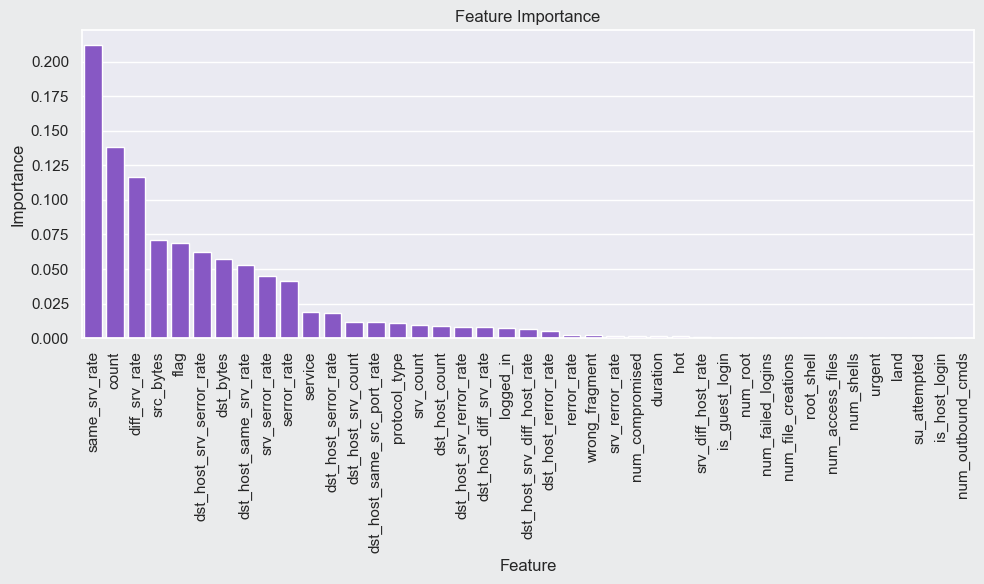

In [8]:
plt.figure(figsize=(10, 6))
sns.barplot(x=X_train.columns[indices], y=importances[indices], hue=X_train.columns[indices], palette=sns.color_palette([p.hex_code('purple')]), legend=False)
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

In [9]:
# Evaluate model performance with and without specific features
def evaluate_model(features):
    X_train_subset = X_train[features]
    X_test_subset = X_test[features]
    rf.fit(X_train_subset, y_train)
    y_pred = rf.predict(X_test_subset)
    acc = accuracy_score(y_test, y_pred)
    fbeta = fbeta_score(y_test, y_pred, beta=10, average='macro')
    return acc, fbeta

# All features
all_features = X_train.columns.tolist()
all_acc, all_fbeta = evaluate_model(all_features)
print(f"All features - Accuracy: {all_acc}, F-beta Score (beta=10): {all_fbeta}")

# Identify least important features (adjust the number as needed)
least_important_features = [X_train.columns[indices[-i-1]] for i in range(20)] # Adjust the number as needed

# Without least important features
important_features = [f for f in X_train.columns if f not in least_important_features]
important_acc, important_fbeta = evaluate_model(important_features)
print(f"Without least important features - Accuracy: {important_acc}, F-beta Score (beta=10): {important_fbeta}")

All features - Accuracy: 0.9266796910377664, F-beta Score (beta=10): 0.9054951021766391
Without least important features - Accuracy: 0.9262527331772133, F-beta Score (beta=10): 0.9049860816660242


# Attack Class Prediction (without Fbeta-score)

In [10]:
# Split data into features (X) and target (y)
X_train = training_df.drop(['target', 'attack_class'], axis=1)
y_train = training_df['attack_class']

X_test = testing_df.drop(['target', 'attack_class'], axis=1)
y_test = testing_df['attack_class']

X_complete = complete_df.drop(['target', 'attack_class'], axis=1)
y_complete = complete_df['attack_class']

In [13]:
# Train a RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, random_state=404, n_jobs=-1)
rf.fit(X_train, y_train)

# Extract feature importances
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

feature_rankings = {}
# Print feature importances in descending order and store in dictionary
print("Feature ranking:")
for rank, idx in enumerate(indices):
    feature_name = X_train.columns[idx]
    importance_value = importances[idx]
    feature_rankings[feature_name] = importance_value
    #print(f"{rank + 1}. Feature: {feature_name}, Importance: {importance_value}")

# Print model scores
print(f"Model score on training data: {rf.score(X_train, y_train)}")
print(f"Model score on testing data: {rf.score(X_test, y_test)}")

# Print feature rankings as dictionary
print("\nFeature rankings:")
print(feature_rankings)

Feature ranking:
Model score on training data: 1.0
Model score on testing data: 0.9617290499540697

Feature rankings:
{'is_attack': 0.2056543274132444, 'count': 0.11920650442888907, 'same_srv_rate': 0.10508972465410206, 'diff_srv_rate': 0.08778113217680307, 'serror_rate': 0.06974624054103938, 'src_bytes': 0.0640681281401352, 'dst_host_serror_rate': 0.06197018656697434, 'dst_host_srv_serror_rate': 0.049256820180968386, 'flag': 0.0491294984749818, 'srv_serror_rate': 0.04423081413644857, 'dst_host_srv_count': 0.03069288273419006, 'dst_host_same_srv_rate': 0.020759103385937262, 'dst_host_diff_srv_rate': 0.01598050573983522, 'logged_in': 0.011148092661821485, 'dst_host_same_src_port_rate': 0.010252432103140747, 'dst_host_rerror_rate': 0.009870914010633081, 'dst_bytes': 0.008271947585178354, 'service': 0.007529789663669806, 'dst_host_srv_diff_host_rate': 0.006014249598252015, 'srv_count': 0.005338970005448468, 'protocol_type': 0.004343821344787647, 'dst_host_count': 0.003041925901452739, 'ds

In [14]:
# Evaluate model performance with and without specific features
def evaluate_model(features):
    X_train_subset = X_train[features]
    X_test_subset = X_test[features]
    rf.fit(X_train_subset, y_train)
    y_pred = rf.predict(X_test_subset)
    acc = accuracy_score(y_test, y_pred)
    return acc

# All features
all_features = X_train.columns.tolist()
all_acc = evaluate_model(all_features)
print(f"All features - Accuracy: {all_acc}")

# Identify least important features (adjust the number as needed)
least_important_features = [X_train.columns[indices[-i-1]] for i in range(20)] # Adjust the number as needed

# Without least important features
important_features = [f for f in X_train.columns if f not in least_important_features]
important_acc = evaluate_model(important_features)
print(f"Without least important features - Accuracy: {important_acc}")

All features - Accuracy: 0.9617290499540697
Without least important features - Accuracy: 0.9657398662198704
